In [2]:
## general imports
import os
import pandas as pd
import numpy as np
from importlib import reload

## visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

## personal modules
import feature_extraction
import algorithms
import evaluate_performance
import augment

In [3]:
os.getcwd()

'c:\\Users\\alessandro\\Documents\\UZH\\Thesis\\code\\test\\augmentation_techniques_test'

In [4]:
training = pd.read_csv("../datasets/training.csv", index_col=0, header=0)
testing = pd.read_csv("../datasets/testing.csv", index_col=0, header=0)

In [5]:
training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4551 entries, 0 to 4550
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   GroupName   4551 non-null   object 
 1   Sex         4551 non-null   object 
 2   AgeDays     4551 non-null   int64  
 3   AgeYears    4551 non-null   float64
 4   RecDate     4551 non-null   object 
 5   SourceFile  4551 non-null   object 
 6   Code        4551 non-null   object 
 7   ID          4551 non-null   int64  
 8   CallFile    4551 non-null   object 
 9   CallTime    4551 non-null   object 
 10  CallType    4551 non-null   object 
 11  Path        4551 non-null   object 
dtypes: float64(1), int64(2), object(9)
memory usage: 462.2+ KB


In [15]:
# class distribution
training.groupby(["Code"]).size()

Code
VBBF083    131
VBBF088    144
VBBF093     44
VBBM071    107
VBBM090    191
VRRF159     33
VRRF180    123
VRRM181    165
VRRM182    302
VRRM183    166
VUKF016    169
VUKF018    510
VUKM004    334
VUKM017    401
VVHM089    151
VWM132     285
VZUF009    217
VZUF014    703
VZUM011    203
VZUM016    172
dtype: int64

In [17]:
# exclude individuals with less than 100 calls
to_exclude = ["VBBF093", "VRRF159"]
training.drop(training[training["Code"].isin(to_exclude)].index, inplace=True)
testing.drop(testing[testing["Code"].isin(to_exclude)].index, inplace=True)

In [18]:
# class distribution
training.groupby(["Code"]).size()

Code
VBBF083    131
VBBF088    144
VBBM071    107
VBBM090    191
VRRF180    123
VRRM181    165
VRRM182    302
VRRM183    166
VUKF016    169
VUKF018    510
VUKM004    334
VUKM017    401
VVHM089    151
VWM132     285
VZUF009    217
VZUF014    703
VZUM011    203
VZUM016    172
dtype: int64

In [19]:
# random sample of obs. to balance classes
m = training.groupby(["Code"]).size().min()
training = training.groupby(["Code"]).sample(n=m, random_state=42)
training.reset_index(inplace=True, drop=True)

m = testing.groupby(["Code"]).size().min()
testing = testing.groupby(["Code"]).sample(n=m, random_state=42).reset_index()
testing.reset_index(inplace=True, drop=True)

training.groupby(["Code"]).size()

Code
VBBF083    107
VBBF088    107
VBBM071    107
VBBM090    107
VRRF180    107
VRRM181    107
VRRM182    107
VRRM183    107
VUKF016    107
VUKF018    107
VUKM004    107
VUKM017    107
VVHM089    107
VWM132     107
VZUF009    107
VZUF014    107
VZUM011    107
VZUM016    107
dtype: int64

## Load original audio signals

In [22]:
os.chdir("C:/Users/alessandro/Documents/UZH/Thesis")
sig_training, sr_training = feature_extraction.audio(training.Path.to_list())
sig_ts, sr_ts = feature_extraction.audio(testing.Path.to_list())

C:\Users\alessandro\Documents\UZH\Thesis\code\my_modules\feature_extraction.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(signals), np.array(sample_rates)


In [23]:
coefs_ts, _ = feature_extraction.features(
    signals=sig_ts, sample_rates=sr_ts, n_subsamples=15, n_mels=40,
    n_mfcc=16, frame_stride=0.0001, fmin=100, fmax=5000
)
X_ts = np.reshape(coefs_ts, newshape=(coefs_ts.shape[0], coefs_ts.shape[1]*coefs_ts.shape[2]))

In [24]:
# testing targets
y_ts, ind_ts = feature_extraction.get_targets(metadata_df=testing)

## Initialize augmenter and number of final calls

In [47]:
# simulate 1 fold of 10-fold cross-validation
training = training.groupby(["Code"]).sample(10, random_state=33)
training.groupby(["Code"]).size()

Code
VBBF083    10
VBBF088    10
VBBM071    10
VBBM090    10
VRRF180    10
VRRM181    10
VRRM182    10
VRRM183    10
VUKF016    10
VUKF018    10
VUKM004    10
VUKM017    10
VVHM089    10
VWM132     10
VZUF009    10
VZUF014    10
VZUM011    10
VZUM016    10
dtype: int64

In [50]:
augmenter = augment.augment_audio(directory="audio/noise/")
m = training.groupby(["Code"]).size().min() # number of original calls

N = [m] + [m * i for i in np.arange(10, 201, 10)] # number of calls after augmentation list
N

[10,
 100,
 200,
 300,
 400,
 500,
 600,
 700,
 800,
 900,
 1000,
 1100,
 1200,
 1300,
 1400,
 1500,
 1600,
 1700,
 1800,
 1900,
 2000]

# Analysis (Random Forest)

In [53]:
# analysis function
def analize(N, sig_training, sr_training, training, X_ts, y_ts, ind_ts):

    ## augmentation
    tr = pd.DataFrame(columns=training.columns)

    for i in training.Code.unique():
        # temporary dataframe
        tmp_df = training.loc[training["Code"] == i].copy(deep=True)

        # indeces of selected individual
        idx = training.loc[training["Code"] == i].index

        tmp_df = augmenter.SigAugment(
            signals=sig_training[idx], sample_rates=sr_training[idx], metadata=tmp_df,
            directory="code/test/augmentation_techniques_test/test_audio", N=N
        )

        tr = tr.append(tmp_df, ignore_index=True)

    print("augmentation factor: {0}\nN: {1}".format(N/m, tr.groupby(["Code"]).size().min()))

    ## feature extraction
    sig_tr, sr_tr = feature_extraction.audio(tr.Path.to_list())
    coefs, _ = feature_extraction.features(
        signals=sig_tr, sample_rates=sr_tr, n_subsamples=15, n_mels=40,
        n_mfcc=16, frame_stride=0.0001, fmin=100, fmax=5000
    )

    # flattening array
    X = np.reshape(coefs, newshape=(coefs.shape[0], coefs.shape[1]*coefs.shape[2]))

    # training targets
    y_tr, _ = feature_extraction.get_targets(metadata_df=tr)

    rf = algorithms.RandForest(random_state=42, do_umap=False)
    rf.fit(X=X, y=y_tr)
    pred_b, prob_b = rf.predict(X=X_ts)

    mat_coef = evaluate_performance.matthews(y=y_ts, yp=pred_b)

    _, acc, f1 = evaluate_performance.metrics(
        y=y_ts, yp=pred_b, 
        y_true=feature_extraction.one_hot(y_ts),
        y_pred=feature_extraction.one_hot(pred_b),
        labels=ind_ts
        )

    auc_rf, _ = evaluate_performance.roc_auc(
        y=y_ts, y_true=feature_extraction.one_hot(y_ts),
        y_score=prob_b, n_classes=len(ind_ts),
        figsize=(5,5), show_figure=False
    )

    return mat_coef, acc, auc_rf, f1

In [54]:
%matplotlib agg

# analysis

d_mcc = {} # dictionary for matthew's corcoef
d_acc = {} # dictionary for accuracy scores
d_auc = {} # dictionary for auc scores
d_f1 = {} # dictionary for f1-score

for i, n in enumerate(N):
    d_mcc[n], d_acc[n], d_auc[n], d_f1[n] = analize(
        N=n, sig_training=sig_training, sr_training=sr_training,
        training=training, X_ts=X_ts, y_ts=y_ts, ind_ts=ind_ts
    )

augmentation factor: 1.0
N: 10
augmentation factor: 10.0
N: 100


C:\Users\alessandro\Documents\UZH\Thesis\code\my_modules\feature_extraction.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(signals), np.array(sample_rates)


augmentation factor: 20.0
N: 200


C:\Users\alessandro\Documents\UZH\Thesis\code\my_modules\feature_extraction.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(signals), np.array(sample_rates)


augmentation factor: 30.0
N: 300


C:\Users\alessandro\Documents\UZH\Thesis\code\my_modules\feature_extraction.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(signals), np.array(sample_rates)


augmentation factor: 40.0
N: 400


C:\Users\alessandro\Documents\UZH\Thesis\code\my_modules\feature_extraction.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(signals), np.array(sample_rates)


augmentation factor: 50.0
N: 500


C:\Users\alessandro\Documents\UZH\Thesis\code\my_modules\feature_extraction.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(signals), np.array(sample_rates)


augmentation factor: 60.0
N: 600


C:\Users\alessandro\Documents\UZH\Thesis\code\my_modules\feature_extraction.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(signals), np.array(sample_rates)


augmentation factor: 70.0
N: 700


C:\Users\alessandro\Documents\UZH\Thesis\code\my_modules\feature_extraction.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(signals), np.array(sample_rates)


augmentation factor: 80.0
N: 800


C:\Users\alessandro\Documents\UZH\Thesis\code\my_modules\feature_extraction.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(signals), np.array(sample_rates)


augmentation factor: 90.0
N: 900


C:\Users\alessandro\Documents\UZH\Thesis\code\my_modules\feature_extraction.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(signals), np.array(sample_rates)


augmentation factor: 100.0
N: 1000


C:\Users\alessandro\Documents\UZH\Thesis\code\my_modules\feature_extraction.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(signals), np.array(sample_rates)


augmentation factor: 110.0
N: 1100


C:\Users\alessandro\Documents\UZH\Thesis\code\my_modules\feature_extraction.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(signals), np.array(sample_rates)


augmentation factor: 120.0
N: 1200


C:\Users\alessandro\Documents\UZH\Thesis\code\my_modules\feature_extraction.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(signals), np.array(sample_rates)


augmentation factor: 130.0
N: 1300


C:\Users\alessandro\Documents\UZH\Thesis\code\my_modules\feature_extraction.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(signals), np.array(sample_rates)


augmentation factor: 140.0
N: 1400


C:\Users\alessandro\Documents\UZH\Thesis\code\my_modules\feature_extraction.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(signals), np.array(sample_rates)


augmentation factor: 150.0
N: 1500


C:\Users\alessandro\Documents\UZH\Thesis\code\my_modules\feature_extraction.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(signals), np.array(sample_rates)


augmentation factor: 160.0
N: 1600


C:\Users\alessandro\Documents\UZH\Thesis\code\my_modules\feature_extraction.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(signals), np.array(sample_rates)


augmentation factor: 170.0
N: 1700


C:\Users\alessandro\Documents\UZH\Thesis\code\my_modules\feature_extraction.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(signals), np.array(sample_rates)


augmentation factor: 180.0
N: 1800


C:\Users\alessandro\Documents\UZH\Thesis\code\my_modules\feature_extraction.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(signals), np.array(sample_rates)


augmentation factor: 190.0
N: 1900


C:\Users\alessandro\Documents\UZH\Thesis\code\my_modules\feature_extraction.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(signals), np.array(sample_rates)


augmentation factor: 200.0
N: 2000


C:\Users\alessandro\Documents\UZH\Thesis\code\my_modules\feature_extraction.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(signals), np.array(sample_rates)
C:\Users\alessandro\Documents\UZH\Thesis\code\my_modules\evaluate_performance.py:165: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=figsize)


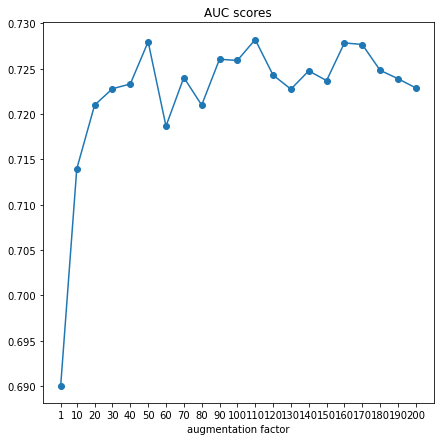

In [57]:
%matplotlib inline
# evaluation AUC

plt.figure(figsize=(7,7))
plt.plot([1] + np.arange(10, 201, 10).tolist(), d_auc.values(), "-o")
plt.title("AUC scores")
plt.xlabel("augmentation factor")
plt.xticks([1] + np.arange(10, 201, 10).tolist())
plt.show()

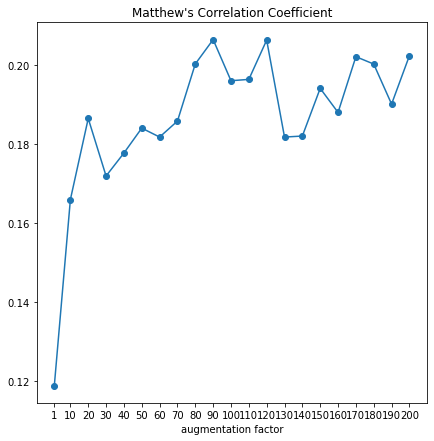

In [58]:
%matplotlib inline
# evaluation AUC

plt.figure(figsize=(7,7))
plt.plot([1] + np.arange(10, 201, 10).tolist(), d_mcc.values(), "-o")
plt.title("Matthew's Correlation Coefficient")
plt.xlabel("augmentation factor")
plt.xticks([1] + np.arange(10, 201, 10).tolist())
plt.show()

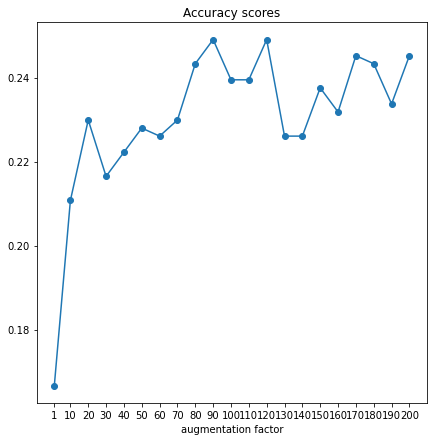

In [59]:
%matplotlib inline
# evaluation AUC

plt.figure(figsize=(7,7))
plt.plot([1] + np.arange(10, 201, 10).tolist(), d_acc.values(), "-o")
plt.title("Accuracy scores")
plt.xlabel("augmentation factor")
plt.xticks([1] + np.arange(10, 201, 10).tolist())
plt.show()

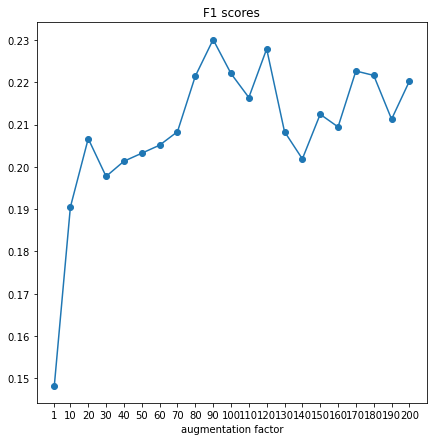

In [60]:
%matplotlib inline
# evaluation AUC

plt.figure(figsize=(7,7))
plt.plot([1] + np.arange(10, 201, 10).tolist(), d_f1.values(), "-o")
plt.title("F1 scores")
plt.xlabel("augmentation factor")
plt.xticks([1] + np.arange(10, 201, 10).tolist())
plt.show()

# Analysis (ANN)

In [63]:
# analysis function
def analize(N, sig_training, sr_training, training, X_ts, y_ts, ind_ts):

    ## augmentation
    tr = pd.DataFrame(columns=training.columns)

    for i in training.Code.unique():
        # temporary dataframe
        tmp_df = training.loc[training["Code"] == i].copy(deep=True)

        # indeces of selected individual
        idx = training.loc[training["Code"] == i].index

        tmp_df = augmenter.SigAugment(
            signals=sig_training[idx], sample_rates=sr_training[idx], metadata=tmp_df,
            directory="code/test/augmentation_techniques_test/test_audio", N=N
        )

        tr = tr.append(tmp_df, ignore_index=True)

    print("augmentation factor: {0}\nN: {1}".format(N/m, tr.groupby(["Code"]).size().min()))

    ## feature extraction
    sig_tr, sr_tr = feature_extraction.audio(tr.Path.to_list())
    coefs, _ = feature_extraction.features(
        signals=sig_tr, sample_rates=sr_tr, n_subsamples=15, n_mels=40,
        n_mfcc=16, frame_stride=0.0001, fmin=100, fmax=5000
    )

    # flattening array
    X = np.reshape(coefs, newshape=(coefs.shape[0], coefs.shape[1]*coefs.shape[2]))

    # training targets
    y_tr, _ = feature_extraction.get_targets(metadata_df=tr)

    ann = algorithms.MLP(n_classes=len(tr.Code.unique()), input_shape=X.shape, random_state=42, do_umap=True)
    _ = ann.fit(X=X, y=feature_extraction.one_hot(y_tr), epochs=20)
    pred_b, prob_b = ann.predict(X=X_ts)

    mat_coef = evaluate_performance.matthews(y=y_ts, yp=pred_b)

    _, acc, f1 = evaluate_performance.metrics(
        y=y_ts, yp=pred_b, 
        y_true=feature_extraction.one_hot(y_ts),
        y_pred=feature_extraction.one_hot(pred_b, num_classes=len(ind_ts)),
        labels=ind_ts
        )

    auc, _ = evaluate_performance.roc_auc(
        y=y_ts, y_true=feature_extraction.one_hot(y_ts),
        y_score=prob_b, n_classes=len(ind_ts),
        figsize=(5,5), show_figure=False
    )

    return mat_coef, acc, auc, f1

In [64]:
%%capture
%matplotlib agg

# analysis

d_mcc = {} # dictionary for matthew's corcoef
d_acc = {} # dictionary for accuracy scores
d_auc = {} # dictionary for auc scores
d_f1 = {} # dictionary for f1-score

for i, n in enumerate(N):
    d_mcc[n], d_acc[n], d_auc[n], d_f1[n] = analize(
        N=n, sig_training=sig_training, sr_training=sr_training,
        training=training, X_ts=X_ts, y_ts=y_ts, ind_ts=ind_ts
    )

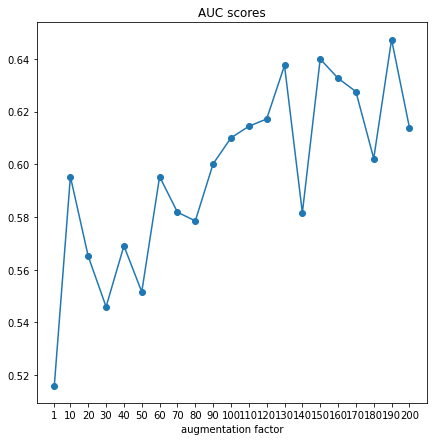

In [65]:
%matplotlib inline
# evaluation AUC

plt.figure(figsize=(7,7))
plt.plot([1] + np.arange(10, 201, 10).tolist(), d_auc.values(), "-o")
plt.title("AUC scores")
plt.xlabel("augmentation factor")
plt.xticks([1] + np.arange(10, 201, 10).tolist())
plt.show()

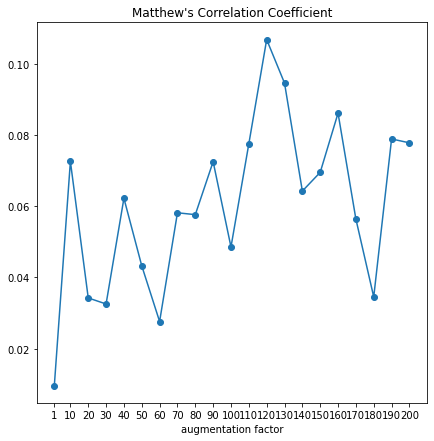

In [66]:
%matplotlib inline
# evaluation AUC

plt.figure(figsize=(7,7))
plt.plot([1] + np.arange(10, 201, 10).tolist(), d_mcc.values(), "-o")
plt.title("Matthew's Correlation Coefficient")
plt.xlabel("augmentation factor")
plt.xticks([1] + np.arange(10, 201, 10).tolist())
plt.show()

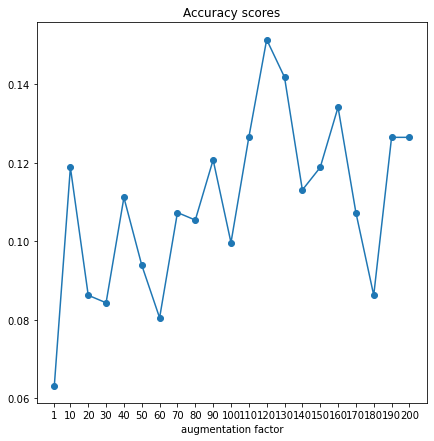

In [67]:
%matplotlib inline
# evaluation AUC

plt.figure(figsize=(7,7))
plt.plot([1] + np.arange(10, 201, 10).tolist(), d_acc.values(), "-o")
plt.title("Accuracy scores")
plt.xlabel("augmentation factor")
plt.xticks([1] + np.arange(10, 201, 10).tolist())
plt.show()

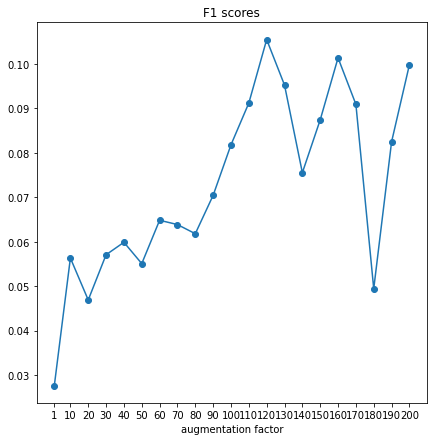

In [68]:
%matplotlib inline
# evaluation AUC

plt.figure(figsize=(7,7))
plt.plot([1] + np.arange(10, 201, 10).tolist(), d_f1.values(), "-o")
plt.title("F1 scores")
plt.xlabel("augmentation factor")
plt.xticks([1] + np.arange(10, 201, 10).tolist())
plt.show()